In [1]:
from __future__ import annotations

%load_ext jupyter_black

In [2]:
import os
from typing import Any

import numpy as np
import xarray as xr

from mesoscaler.core import Mesoscale, P0, DependentDataset
from mesoscaler.enums import (
    # - independent variables
    Dimensions,
    Coordinates,
    # - dependent variables
    ERA5,
    GEOPOTENTIAL,
    SPECIFIC_HUMIDITY,
    TEMPERATURE,
    U_COMPONENT_OF_WIND,
    V_COMPONENT_OF_WIND,
    URMA,
    SURFACE_PRESSURE,
    TEMPERATURE_2M,
    SPECIFIC_HUMIDITY_2M,
    U_WIND_COMPONENT_10M,
    V_WIND_COMPONENT_10M,
    SURFACE_PRESSURE,
)

_test_data = "../tests/data"

urma_store = os.path.join(_test_data, "urma.zarr")
era5_store = os.path.join(_test_data, "era5.zarr")

print("\n".join(f"{t.__name__} = {tuple(t)}" for t in (Dimensions, Coordinates, URMA, ERA5)))

Dimensions = (T, Z, Y, X)
Coordinates = (time, vertical, latitude, longitude)
URMA = (total_cloud_cover, ceiling, u_wind_component_10m, v_wind_component_10m, wind_speed_10m, wind_speed_gust, wind_direction_10m, temperature_2m, dewpoint_temperature_2m, specific_humidity_2m, surface_pressure, visibility, orography)
ERA5 = (geopotential, specific_humidity, temperature, u_component_of_wind, v_component_of_wind, vertical_velocity)


In [3]:
URMA_GRID_RESOLUTION = 2.5  # km
ERA5_GRID_RESOLUTION = 30.0  # km (0.25 deg)
DX = 200  # km
DY = 175  # km
D = DX, DY = np.array([200, 175])
pressure_levels = [P0, 1000.0, 925.0, 850.0, 700.0, 500.0, 300.0]
scale = Mesoscale(DX, DY, pressure=pressure_levels, rate=15)

extent = scale.to_numpy(units="km")
extent[0] /= URMA_GRID_RESOLUTION
extent[1:] /= ERA5_GRID_RESOLUTION

print(scale, extent, sep="\n")
print(
    (URMA_GRID_RESOLUTION / scale.dx[1:]),
    sep="\n",
)

sx = scale.scale.copy()
sx[0] *= URMA_GRID_RESOLUTION
sx[1:] *= ERA5_GRID_RESOLUTION
sy = scale.scale.copy()
sy[0] *= URMA_GRID_RESOLUTION
sy[1:] *= ERA5_GRID_RESOLUTION
print(np.c_[sx, sy], sep="\n")

(scale.dx[1:] / 30) / 80

Mesoscale(size=7):
- scale: [ 1.00  3.81  7.52  9.43 11.69 13.52 14.78]
-   hpa: [1013.25 1000.00  925.00  850.00  700.00  500.00  300.00]
-    dx: [ 200.00  761.70 1504.23 1885.10 2338.60 2704.87 2956.21]
-    dy: [ 175.00  666.49 1316.20 1649.47 2046.27 2366.76 2586.68]
...
- dy: [ 175.00  666.49 1316.20 1649.47 2046.27 2366.76 2586.68]
[[80.         70.        ]
 [25.39003874 22.2162839 ]
 [50.14099032 43.87336653]
 [62.83678289 54.98218503]
 [77.9531895  68.20904081]
 [90.16226411 78.89198109]
 [98.54020502 86.22267939]]
[0.00328213 0.00166198 0.00132619 0.00106902 0.00092426 0.00084568]
[[  2.5          2.5       ]
 [114.25517434 114.25517434]
 [225.63445644 225.63445644]
 [282.76552302 282.76552302]
 [350.78935273 350.78935273]
 [405.73018849 405.73018849]
 [443.4309226  443.4309226 ]]


array([0.31737548, 0.62676238, 0.78545979, 0.97441487, 1.1270283 ,
       1.23175256])

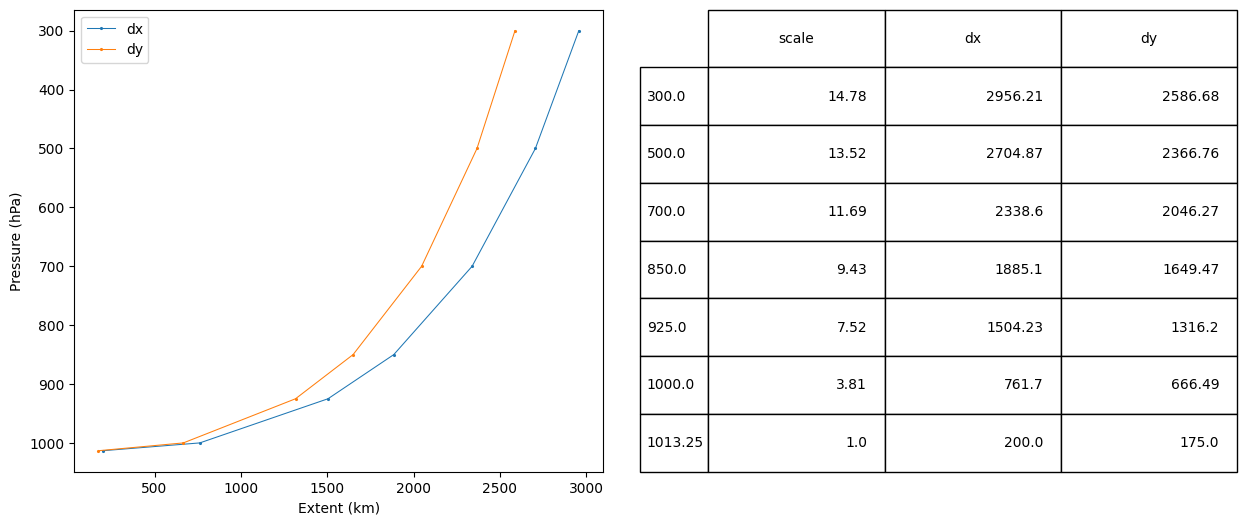

In [4]:
import matplotlib.pyplot as plt

X1, X2, Y = scale.dx, scale.dy, scale.hpa
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(121)
ax.invert_yaxis()
ax.plot(X1, Y, linestyle="-", linewidth=0.75, marker=".", markersize=2.5)
ax.plot(X2, Y, linestyle="-", linewidth=0.75, marker=".", markersize=2.5)
ax.set_ylabel("Pressure (hPa)")
ax.set_xlabel("Extent (km)")
ax.legend(["dx", "dy"])

ax2 = fig.add_subplot(122)
df = scale.to_pandas()

ax2.axis("off")
mpl_table = ax2.table(
    cellText=df.to_numpy().round(2).astype(str).tolist(),
    rowLabels=df.index.tolist(),
    bbox=[0, 0, 1, 1],  # type: ignore
    colLabels=df.columns.tolist(),
)

In [5]:
# define the variables and levels

era5_dvars = [
    GEOPOTENTIAL,
    SPECIFIC_HUMIDITY,
    TEMPERATURE,
    U_COMPONENT_OF_WIND,
    V_COMPONENT_OF_WIND,
]
urma_dvars = [
    SURFACE_PRESSURE,
    TEMPERATURE_2M,
    SPECIFIC_HUMIDITY_2M,
    U_WIND_COMPONENT_10M,
    V_WIND_COMPONENT_10M,
]
assert len(era5_dvars) == len(urma_dvars), "vard must be the same length in order to be resampled"

era5 = DependentDataset.from_zarr(era5_store, era5_dvars)  # get datasets
urma = DependentDataset.from_zarr(urma_store, urma_dvars)  # get datasets

In [6]:
print(
    era5.to_array().shape,
    urma.to_array().shape,
    scale.hpa.shape,
    sep="\n",
)

(5, 2, 37, 721, 1440)
(5, 2, 1, 1597, 2345)
(7,)


In [7]:
a = np.stack([era5[dvar].to_numpy() for dvar in era5.data_vars])
a.shape  # (Variable, Time, Level, Latitude, Longitude)

(5, 2, 37, 721, 1440)

In [8]:
time = era5.time.to_numpy()
start, stop = time

In [9]:
# scott afb
from mesoscaler.utils import join_kv

longitude = -89.835
latitude = 38.54

sampler = scale.resample(urma, era5, height=70, width=80)
arr = sampler(longitude, latitude, time=np.s_[start:stop])


print(
    join_kv(
        "Shapes:",
        ("dimensions", ("V",) + tuple(Dimensions)),
        ("urma", urma.to_array().shape),
        ("era5", era5.to_array().shape),
        ("resampled", arr.shape),
    )
)

Shapes:
- dimensions: ('V', T, Z, Y, X)
-       urma: (5, 2, 1, 1597, 2345)
-       era5: (5, 2, 37, 721, 1440)
-  resampled: (5, 2, 7, 70, 80)


In [10]:
(
    xr.DataArray(
        arr,
        dims=["dvars", Dimensions.T, Dimensions.Z, Dimensions.Y, Dimensions.X],
        coords={
            "dvars": era5_dvars,
            Coordinates.vertical: (Coordinates.vertical.axis, scale.hpa),
            Coordinates.time: (Coordinates.time.axis, time),
        },
    ).to_dataset("dvars")
)

<xarray.Dataset>
Dimensions:              (T: 2, Z: 7, Y: 70, X: 80)
Coordinates:
    vertical             (Z) float64 1.013e+03 1e+03 925.0 ... 700.0 500.0 300.0
    time                 (T) datetime64[ns] 2019-01-02 2019-01-02T01:00:00
Dimensions without coordinates: T, Z, Y, X
Data variables:
    geopotential         (T, Z, Y, X) float32 0.0 0.0 0.0 ... 242.7 243.1 243.1
    specific_humidity    (T, Z, Y, X) float32 0.0 0.0 0.0 ... 7.494 8.985 6.694
    temperature          (T, Z, Y, X) float32 0.0 0.0 0.0 ... 6.045 7.49 7.664
    u_component_of_wind  (T, Z, Y, X) float32 0.0 0.0 0.0 ... 0.8514 -2.306
    v_component_of_wind  (T, Z, Y, X) float32 0.0 0.0 0.0 ... 1.252 2.759 -1.764

In [11]:
def locate(dvar: Any, level: float, time: int = 0) -> tuple[slice | int, ...]:
    """function to help selecting a specific frame from the 5 dimensional array"""
    if level == P0:
        return (urma_dvars.index(dvar), time, pressure_levels.index(level)) + np.s_[:, :]
    return (era5_dvars.index(dvar), time, pressure_levels.index(level)) + np.s_[:, :]


locate(GEOPOTENTIAL, 925, 1)

(0, 1, 2, slice(None, None, None), slice(None, None, None))

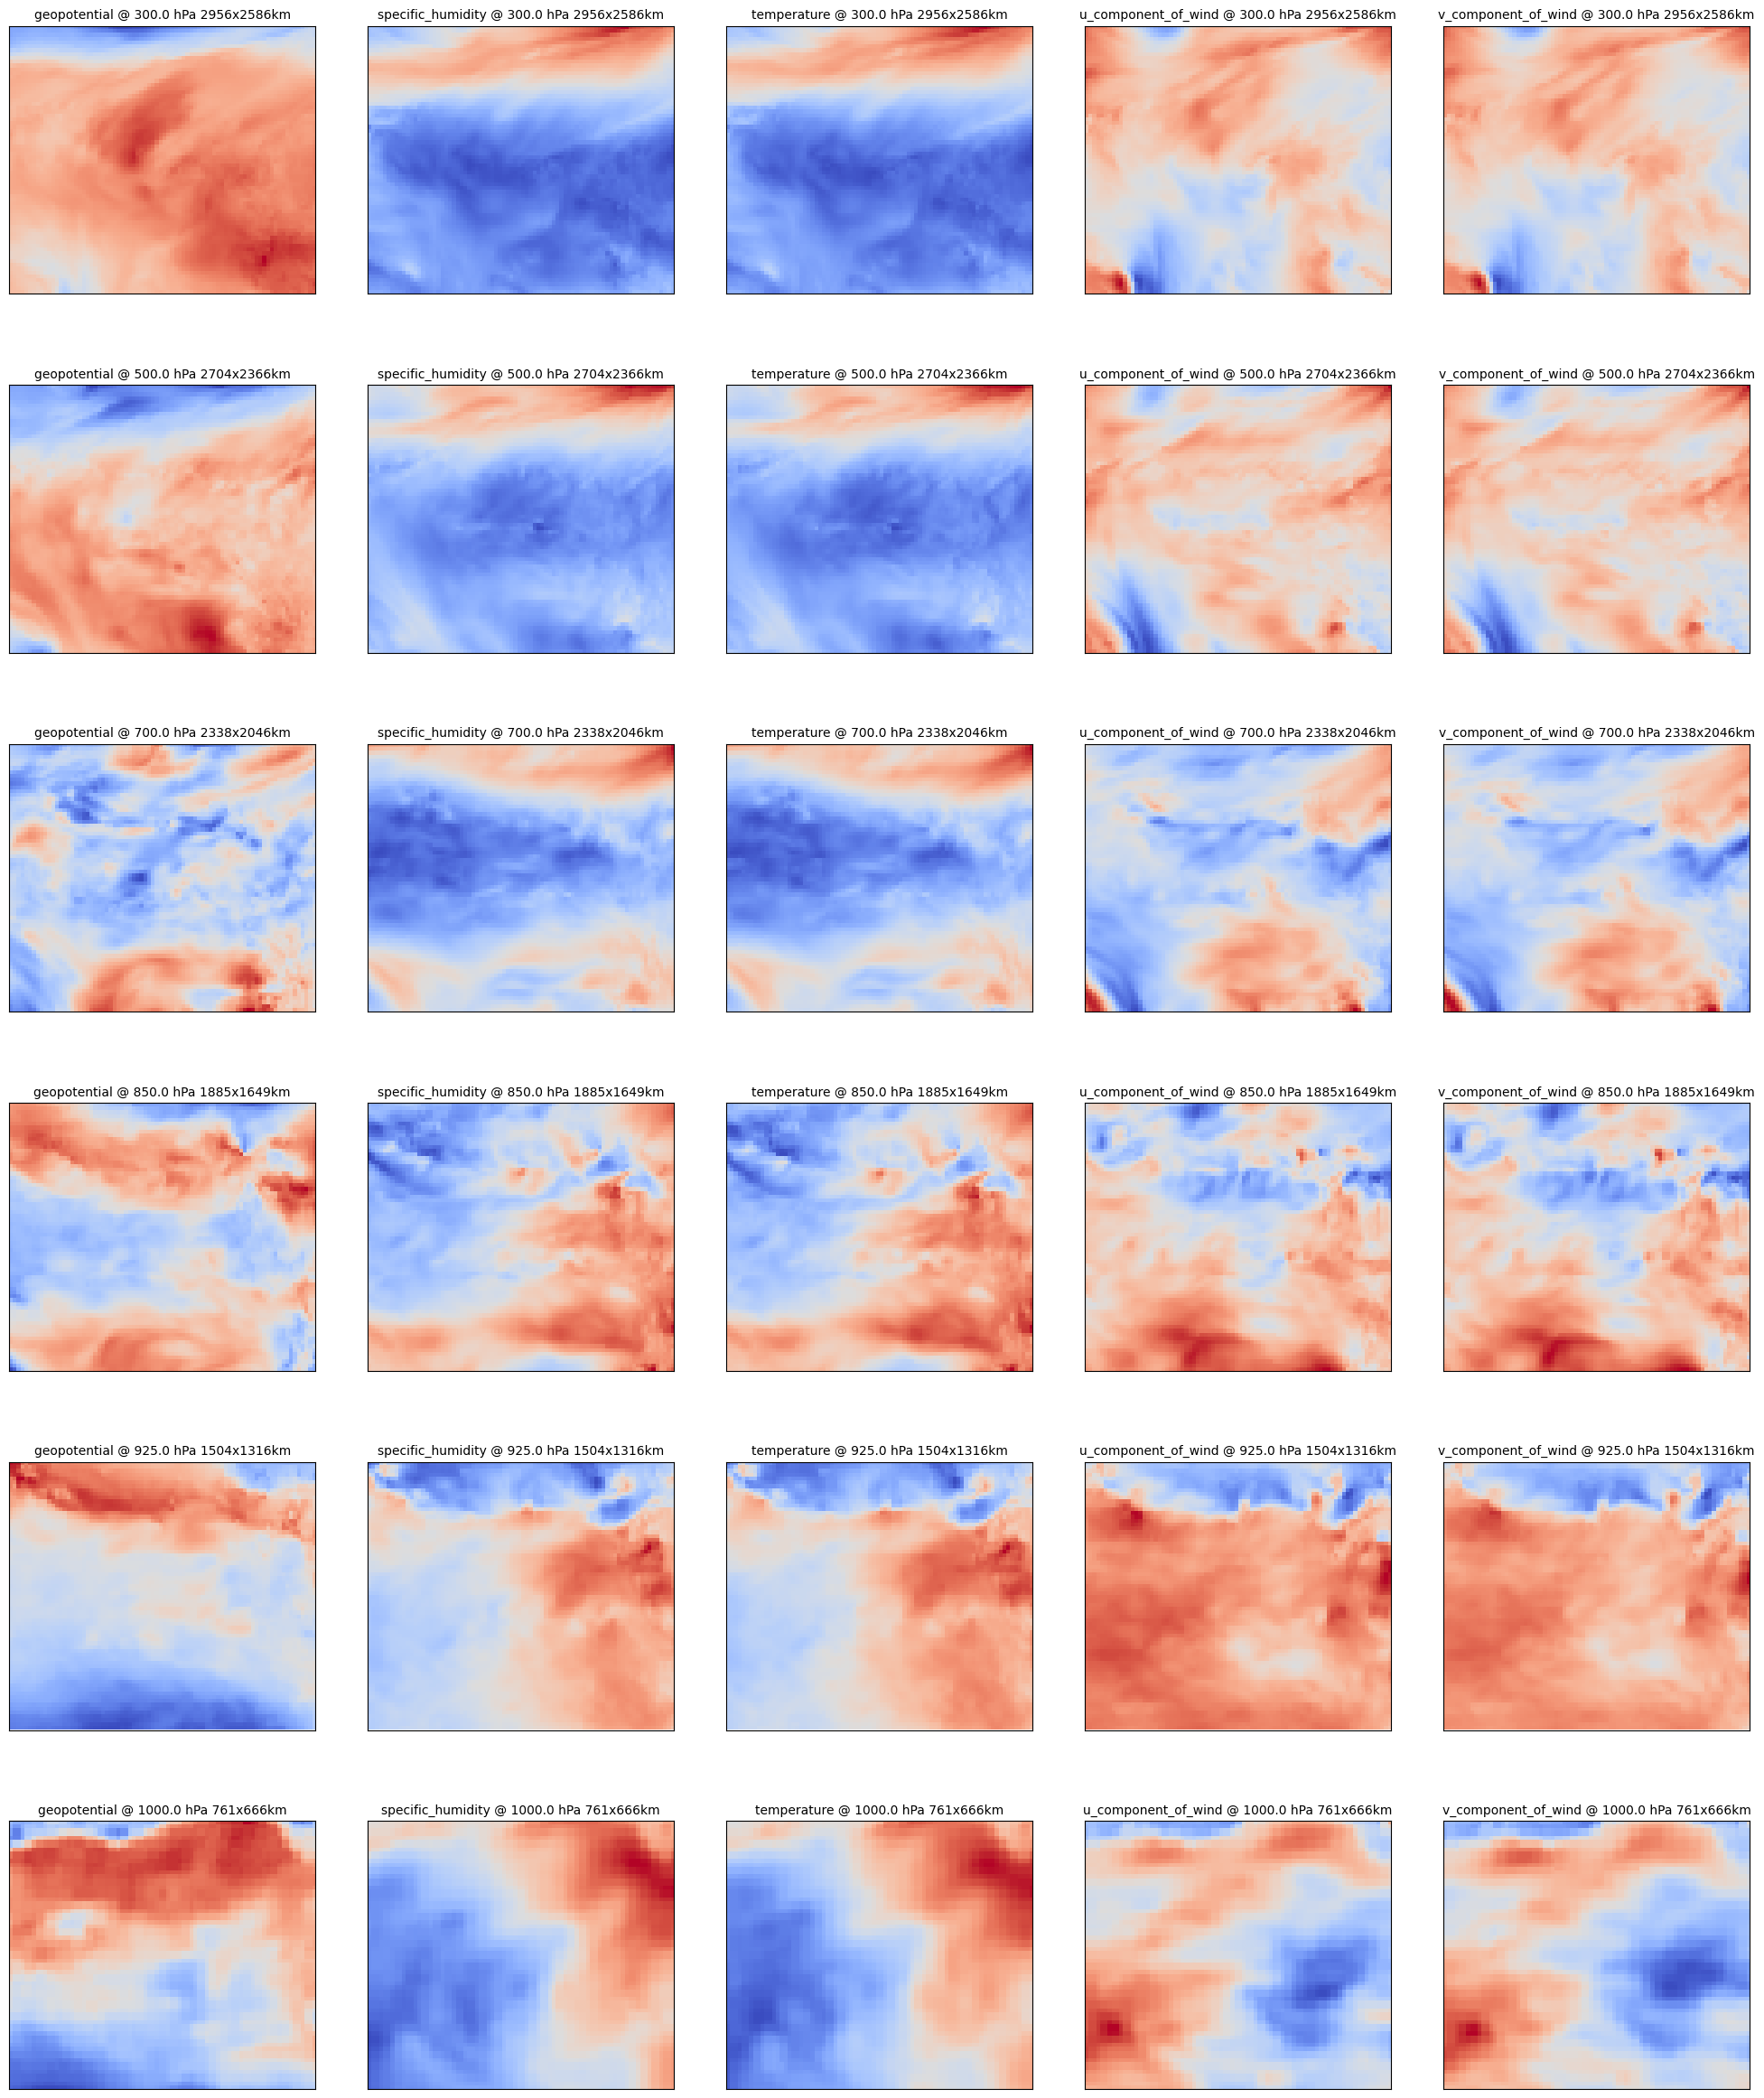

In [12]:
data_vars = era5_dvars
era5_levels = pressure_levels[1:]
e = np.abs(scale.stack_extent()[1:])
fig, axes = plt.subplots(len(era5_levels), len(era5_dvars), figsize=(4 * len(era5_dvars), 4 * len(era5_levels)))
fig.tight_layout()
axes = axes[::-1]
for i, level in enumerate(era5_levels):
    for j, dvar in enumerate(data_vars):
        ax = axes[i, j]
        ax.imshow(arr[locate(dvar, level, 1)], cmap="coolwarm")
        ax.set_title(f"{dvar} @ {level} hPa {int(e[i,0])}x{int(e[i,-1])}km", fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])